In [1]:
import numpy as np
import pysindy as ps

from scipy.integrate import solve_ivp
from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, van_der_pol, lotka

import matplotlib.pyplot as plt

from numpy import genfromtxt

import deepSI
from deepSI import System_data

import torch
from torch import nn
from torch.nn import functional as F

import csv
import os

from scipy.io import loadmat

import torch.nn.utils.prune as prune

## check utils
from utils import load_data, normalize

from matplotlib.colors import LinearSegmentedColormap

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# X = torch.rand((100,2), requires_grad=True)

# def LpLoss(y_pred, y_true):
#   torch.linalg.norm(X, ord=0.5)
#   return
  

In [3]:
x_data, u_data, y_data, th_data = load_data(pc=0, set="SILVERCUBE")

# for SNL100k
# u_data = u_data.T

In [4]:
# train_samples = round(x_data.shape[0]*0.9)
# test_samples = round(x_data.shape[0]*0.1)
train_samples = 500000
test_samples = 100000
x_train, u_train = x_data[:train_samples,:], u_data[:train_samples]
x_val,     u_val = x_data[-test_samples:,:], u_data[-test_samples:]

In [5]:
x_data = x_train
u_data = u_train

input  = x_data[:-1,:]
u_input = u_data[:-1]

output = x_data[1:,:]

# check if right data is selected
np.sum((input[1:,:]-output[:-1,:]))

0.0

In [6]:
# building theta matrix with only necesary features
# in this case [1 x1 x2 u np.sin(x1)]

#MSD1500k
# Theta = np.c_[np.ones(input.shape[0]), input[:,0], input[:,1], u_input, np.sin(input[:,0])]
#SNL100k
Theta = np.c_[input[:,0], input[:,1], u_input, input[:,1]**3, np.ones(input.shape[0]), input[:,0]**2]
# Theta = np.c_[np.ones(input.shape[0]), input[:,0], input[:,1], u_input, input[:,0]**3]
Theta.shape

(499999, 6)

In [7]:
# validation

val_input, val_u_input  = x_val[:-1,:], u_val[:-1]
val_output              = x_val[1:,:]

#MSD1500k
# Theta_val  = np.c_[np.ones(val_input.shape[0]), val_input[:,0], val_input[:,1], val_u_input, np.sin(val_input[:,0])]
#SNL100k
Theta_val = np.c_[val_input[:,0], val_input[:,1], val_u_input, val_input[:,1]**3, np.ones(val_input.shape[0]), val_input[:,0]**2]

Theta_val_t  = torch.as_tensor(Theta_val).to(torch.float32)
val_output_t = torch.as_tensor(val_output).to(torch.float32)

Theta_val_t.shape, val_output_t.shape

(torch.Size([99999, 6]), torch.Size([99999, 2]))

In [8]:
def validation(x_in, x_out, criterion, model):
    model.eval()

    with torch.no_grad():
        output = model(x_in)
        val_loss = criterion(output, x_out)

    model.train()

    return val_loss, model

In [9]:
# converting necesary data to tensors
Theta_t  = torch.as_tensor(Theta).to(torch.float32)
output_t = torch.as_tensor(output).to(torch.float32)
Theta_t.shape, output_t.shape

(torch.Size([499999, 6]), torch.Size([499999, 2]))

In [10]:
class f_net(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super(f_net, self).__init__()
        
        self.layer = nn.Linear(n_in, n_out, bias=False)

        # initialize weights
        # print(self.layer.weight)
        # torch.nn.init.xavier_uniform_(self.layer.weight)
        
        # print(self.layer.weight)
        # self.layer.weight = torch.nn.Parameter(torch.tensor([[1e-5, 1e-5, 1e-5, 1e-5, 1e-5],[1e-5, 1e-5, 1e-5, 1e-5, 1e-5]]), requires_grad=True)
        # self.layer.weight = torch.nn.Parameter(torch.tensor([[1e-6, 1, -0.05, 1e-6, -0.05, 0],[1e-6, 1e-6, 1, -0.001, 0, -0.05]]), requires_grad=True)
        # self.layer.weight = torch.nn.Parameter(torch.cat((self.layer.weight[:,:-1], torch.tensor([[0],[-0.05]])), 1), requires_grad=True)

    def forward(self, x):
        out = self.layer(x)
        return out

In [11]:
# loss function
def criterion(X_pred, X_true):
    return 1/X_pred.shape[0] * torch.sum((X_pred-X_true)**2)
    # return torch.sum((X_pred-X_true)**2)

# criterion = nn.MSELoss()

In [12]:
# initialize model
n_in  = Theta_t.shape[-1]
n_out = output_t.shape[-1]

model = f_net(n_in, n_out)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
# optimizer = torch.optim.SGD(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # , lr=1e-3

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

epochs = 12500
losses = []
val_losses = []

# container for params
params = None

min_loss = 1

for epo in range(epochs):
    pred = model(Theta_t)

    loss = criterion(pred, output_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()

    losses.append(loss.detach().numpy())

    if loss<min_loss:
        min_loss = loss
        best_param = [*model.parameters()][0].detach().numpy()
        best_epo = epo

    if (epo%(epochs//10)==0 or epo==epochs-1) and epo != 0:
        epo_p = epo if epo != epochs-1 else epo+1

        validation
        val_loss, model = validation(Theta_val_t, val_output_t, criterion, model)
        val_losses.append(val_loss)

        print("Epoch {} train loss: {}, val loss: {}".format(epo_p, loss, val_loss))
        # print("lr: {}".format(optimizer.param_groups[0]["lr"]))
        # print([*model.parameters()][0].detach().numpy())

    if epo%(epochs//100)==0:
        param_epo = [*model.parameters()][0].detach().flatten().numpy()
        params = np.c_[params, param_epo] if params is not None else param_epo

Epoch 1250 train loss: 0.0038889937568455935, val loss: 0.0038782430347055197
Epoch 2500 train loss: 0.0011710725957527757, val loss: 0.0011679554590955377
Epoch 3750 train loss: 0.0004933169693686068, val loss: 0.0004918338963761926
Epoch 5000 train loss: 0.00014038370864000171, val loss: 0.000139894662424922
Epoch 6250 train loss: 1.906252327898983e-05, val loss: 1.898031223390717e-05
Epoch 7500 train loss: 6.132041221462714e-07, val loss: 6.096989295656385e-07
Epoch 8750 train loss: 1.735047994166905e-09, val loss: 1.7224628390266616e-09
Epoch 10000 train loss: 1.963569552180383e-13, val loss: 1.9307652536233039e-13


KeyboardInterrupt: 

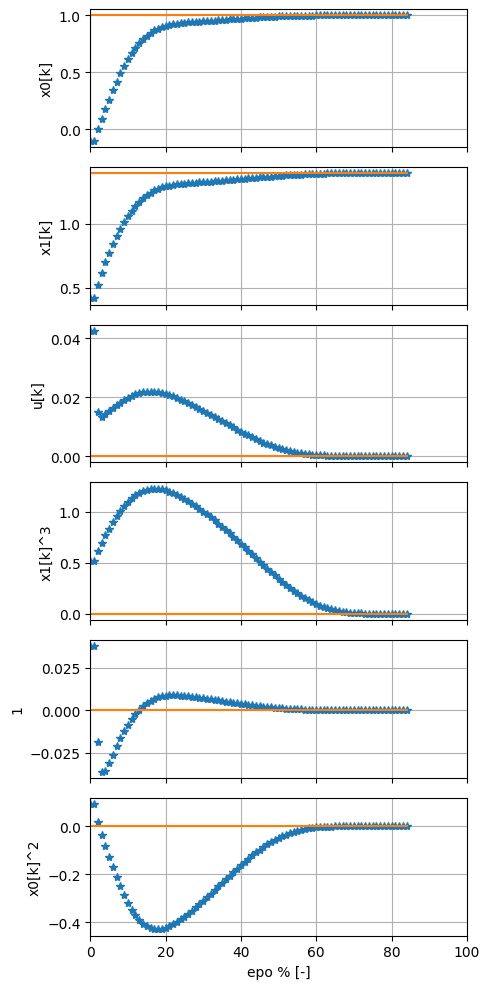

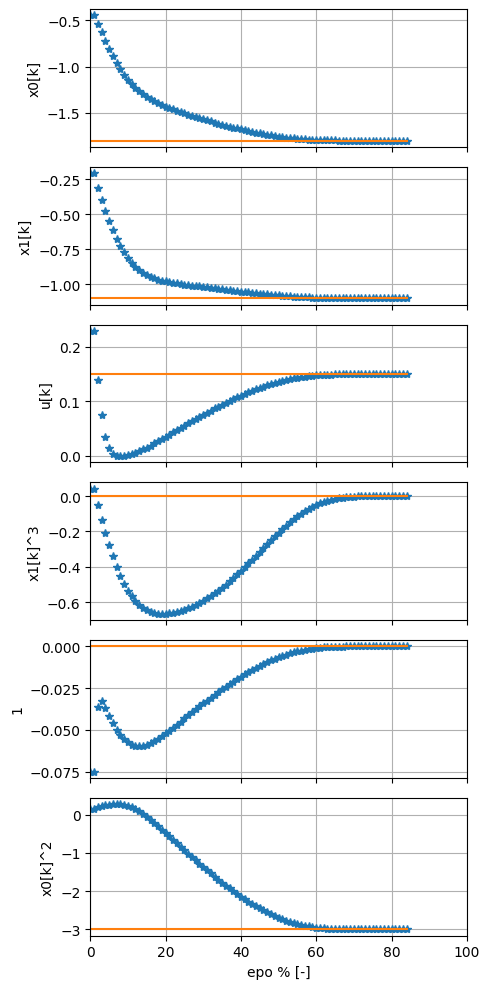

In [13]:
nr, nc = params.shape
eq1_param = params[:nr//2,:]
eq2_param = params[nr//2:,:]

labels = ["x0[k]", "x1[k]", "u[k]", "x1[k]^3", "1", "x0[k]^2"]

truth_eq1 = [1., 1.4, 0, 0, 0, 0]

nr, nc = eq1_param.shape
fig, axes = plt.subplots(nr, 1, figsize=(5, 10), sharex=True)
fig.subplots_adjust(hspace=0)

for i, row in enumerate(eq1_param):
    axes[i].plot(row,"*")
    axes[i].plot(truth_eq1[i]*np.ones(row.shape))
    axes[i].grid()
    axes[i].set_xlim([0, 100])
    axes[i].set_ylabel(labels[i])
axes[i].set_xlabel("epo % [-]")    

plt.tight_layout()
plt.show()

truth_eq2 = [-1.8, -1.1, 0.15, 0, 0,-3]

nr, nc = eq2_param.shape
fig, axes = plt.subplots(nr, 1, figsize=(5, 10), sharex=True)
fig.subplots_adjust(hspace=0)

for i, row in enumerate(eq2_param):
    axes[i].plot(row,"*")
    axes[i].plot(truth_eq2[i]*np.ones(row.shape))
    axes[i].grid()
    axes[i].set_xlim([0, 100])
    axes[i].set_ylabel(labels[i])
axes[i].set_xlabel("epo % [-]")    

plt.tight_layout()
plt.show()

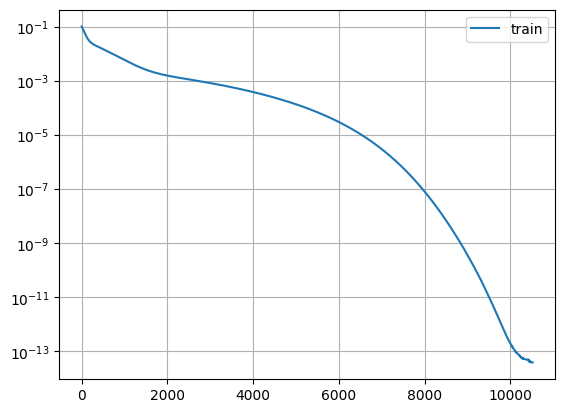

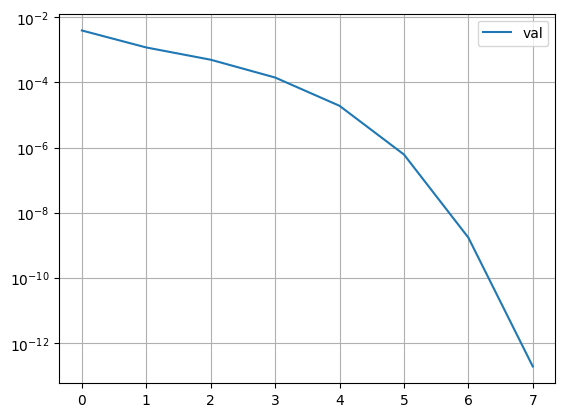

In [14]:
plt.semilogy(losses)
# plt.semilogy(val_losses)
plt.legend(["train"])
plt.grid()
plt.show()

# plt.semilogy(losses)
plt.semilogy(val_losses)
plt.legend(["val"])
plt.grid()
plt.show()

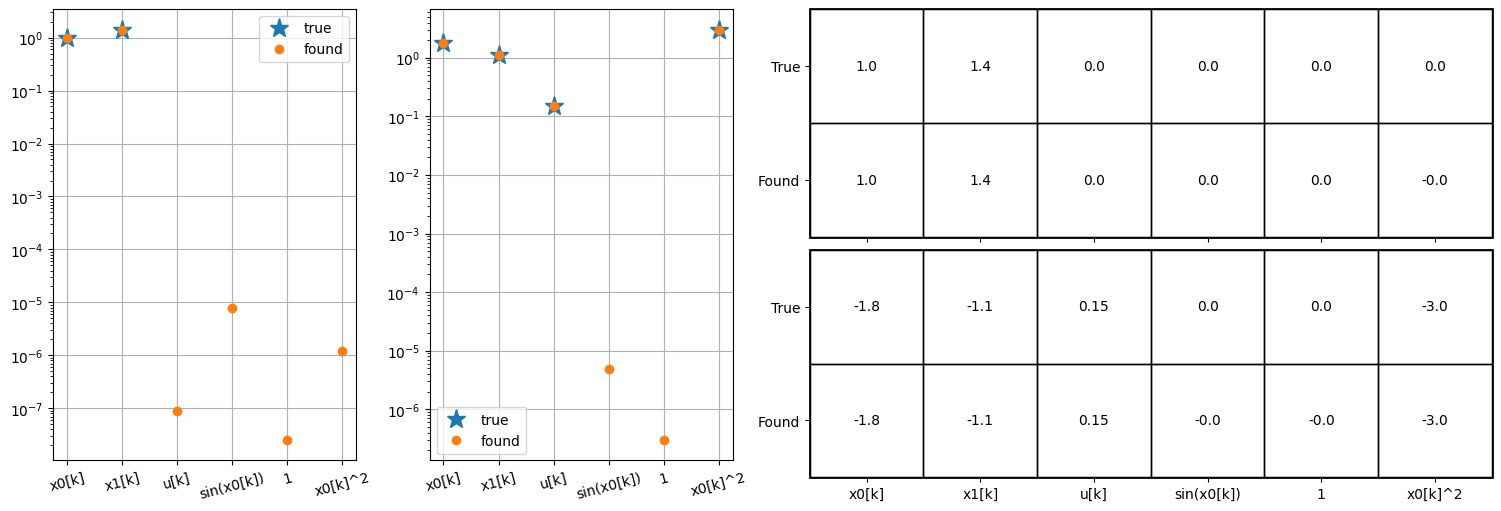

In [15]:
found = [*model.parameters()][0].detach().numpy()

#MSD1500k
# true = np.array([[0, 0], [1, -0.1], [1, 0.5], [0, 0.1], [0, -0.2]])
# x_labels = ["1", "x0[k]", "x1[k]", "u[k]", "sin(x0[k])"]
#SNL100kk
true = np.array([[1, -1.8], [1.4, -1.1], [0, 0.15], [0, 0], [0,0], [0,-3]])
x_labels = ["x0[k]", "x1[k]", "u[k]", "sin(x0[k])", "1", "x0[k]^2"]

fig = plt.figure(layout='constrained', figsize=(15, 5))
subfigs = fig.subfigures(1, 2, wspace=0.01)

# subfigs[0].set_facecolor('grey')
# subfigs[1].set_facecolor('grey')

axsnest0 = subfigs[0].subplots(1, 2, sharex=True)
axsnest1 = subfigs[1].subplots(2, 1, sharex=True)

ax1, ax2 = axsnest0[0], axsnest0[1]

ax1.semilogy(np.abs(true[:,0]), "*", markersize=14)
ax1.semilogy(np.abs(found[0,:]), "o", markersize=6)
ax1.grid()
ax1.set_xticks(np.arange(0,len(x_labels),1))
ax1.set_xticklabels(x_labels, rotation=15)
# ax1.set_ylim([9e-1, 5])
ax1.legend(["true","found"])

ax2.semilogy(np.abs(true[:,1]), "*", markersize=14)
ax2.semilogy(np.abs(found[1,:]), "o", markersize=6)
ax2.set_xticks(np.arange(0,len(x_labels),1))
ax2.set_xticklabels(x_labels, rotation=15)
# ax2.set_ylim([9e-1, 5])
ax2.grid()
ax2.legend(["true","found"])

# right side
ax1, ax2 = axsnest1[0], axsnest1[1]

data1 = np.vstack((true[:,0],found[0,:]))
data2 = np.vstack((true[:,1],found[1,:]))
cmap_white = LinearSegmentedColormap.from_list("white", [(1, 1, 1), (1, 1, 1)])

im = ax1.imshow(data1, cmap=cmap_white)

ax1.set_xticks(np.arange(data1.shape[1]), labels=x_labels)
ax1.set_yticks(np.arange(data1.shape[0]), labels=["True", "Found"])

for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        text = ax1.text(j, i, round(data1[i, j],3),
                       ha="center", va="center", color="k")
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
        ax1.add_patch(rect)

ax1.patch.set_linewidth(2.0)        
ax1.patch.set_edgecolor('black')

# second
im = ax2.imshow(data2, cmap=cmap_white)

ax2.set_xticks(np.arange(data2.shape[1]), labels=x_labels)
ax2.set_yticks(np.arange(data2.shape[0]), labels=["True", "Found"])

for i in range(data2.shape[0]):
    for j in range(data2.shape[1]):
        text = ax2.text(j, i, round(data2[i, j], 3),
                       ha="center", va="center", color="k")
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
        ax2.add_patch(rect)

ax2.patch.set_linewidth(2.0)        
ax2.patch.set_edgecolor('black')

plt.show()
